In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import nibabel as nib


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

## Functions

In [2]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood_indices, neighborhood


def get_magnitude(v):
    return np.linalg.norm(v)


def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0, 0
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")

The vectors do not differ by a lot: 14.04 degrees


# Test case
## Load deformation field

In [3]:
CURR_IDX = 350  # Only consider the correspondences of this index

# Input parameters
base_path = "data/base_unique_correspondences/registered_output/deformation3d.npy"
mpoints_path = "data/base_unique_correspondences/mpoints.npy"
fpoints_path = "data/base_unique_correspondences/fpoints.npy"
lut_path = "output/final_case/lut_data_7x7.csv"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]

# Change the 0th index in each element to 0
mpoints[:, 0] = 0
fpoints[:, 0] = 0

cvectors = fpoints - mpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("First five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

Correspondence point shape: (1326, 3)
First five fixed points:
 [[  0.  10. 173.]
 [  0.  10. 174.]
 [  0.  10. 175.]
 [  0.  10. 176.]
 [  0.  10. 181.]]
First five moving points:
 [[  0.  17. 178.]
 [  0.  17. 179.]
 [  0.  18. 172.]
 [  0.  18. 180.]
 [  0.  15. 187.]]
First five correspondence vectors:
 [[ 0. -7. -5.]
 [ 0. -7. -5.]
 [ 0. -8.  3.]
 [ 0. -8. -4.]
 [ 0. -5. -6.]]


## Remove INTERSECTING correspondences

In [4]:
def remove_intersections(mpoints: np.ndarray, fpoints: np.ndarray, idx: int=0) -> tuple:
    """
    Remove intersecting correspondences between the moving and fixed points.
    
    Parameters:
    mpoints (np.ndarray): The moving points.
    fpoints (np.ndarray): The fixed points.
    idx (int): The index of the correspondences.
    
    Returns:
    tuple: The moving and fixed correspondences with intersecting points removed.
    """
    mcorrespondences = []
    fcorrespondences = []

    mpts = mpoints.copy()[:, 1:]
    fpts = fpoints.copy()[:, 1:]

    # Swap correspondences if they intersect
    fpts, ipts = correspondences.swap_correspondences(mpts, fpts)
    min_intersection_count = len(ipts)
    curr_fpts = fpts
    # Keep swapping until the number of intersections no longer decreases
    while True:
        fpts, ipts_temp = correspondences.swap_correspondences(mpts, fpts)
        intersection_count = len(ipts_temp)
        #print("Number of intersecting points:", intersection_count)
        if intersection_count < min_intersection_count:
            min_intersection_count = intersection_count
            curr_fpts = fpts
        else:
            break
    fpts = curr_fpts

    # Detect intersecting line segments
    intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(mpts, fpts)

    # Remove intersecting segments from correspondences
    new_mpts = mpts.copy()
    new_fpts = fpts.copy()
    while len(intersecting_indices) != 0:
        new_mpts = [element for i, element in enumerate(new_mpts) if i not in intersecting_indices[:, 0]]
        new_fpts = [element for i, element in enumerate(new_fpts) if i not in intersecting_indices[:, 0]]
        intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
        num_intersections = len(intersecting_indices)
        #print("Number of intersecting segments left:", num_intersections)
        if num_intersections != 0:
            intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
    new_mpts = np.array(new_mpts)
    new_fpts = np.array(new_fpts)


    new_col = np.full((new_mpts.shape[0], 1), idx)
    new_mpts = np.hstack((new_col, new_mpts))
    new_fpts = np.hstack((new_col, new_fpts))
    mcorrespondences.append(new_mpts)
    fcorrespondences.append(new_fpts)

    mcorrespondences = np.concatenate(mcorrespondences, axis=0)
    fcorrespondences = np.concatenate(fcorrespondences, axis=0)
    return mcorrespondences, fcorrespondences

# Remove intersecting correspondences
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

Starting number of correspondences: 1326
Number of correspondences after removing intersections: 1246
Number of correspondences removed: 80


## Compute Jacobian of points with INTERSECTIONS removed.

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05384325981140137s
Computing dy
dy calculated in 0.17346763610839844s
Computing dx
dx calculated in 0.2729008197784424s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.0468287467956543s
Computing dy
dy calculated in 0.17435336112976074s
Computing dx
dx calculated in 0.2770700454711914s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 168
After - minimum Jacobian determinant: -4.141267670622895
After - maximum Jacobian determinant: 8.847872374160026


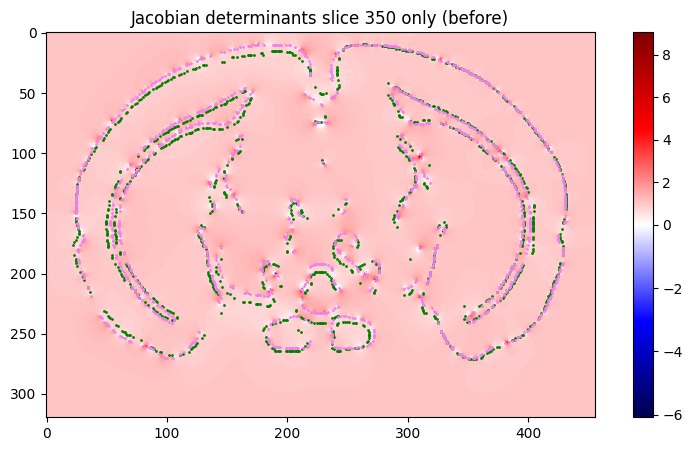

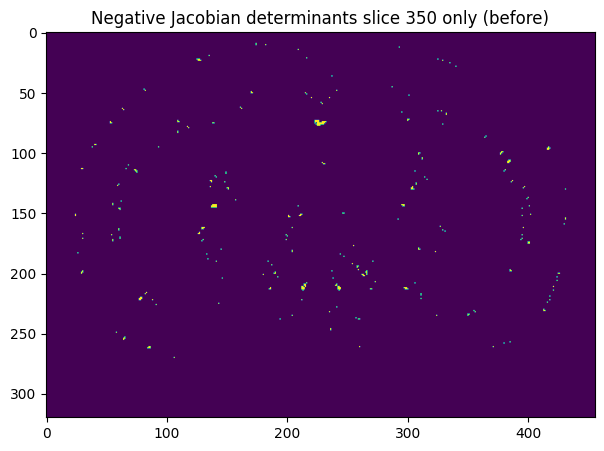

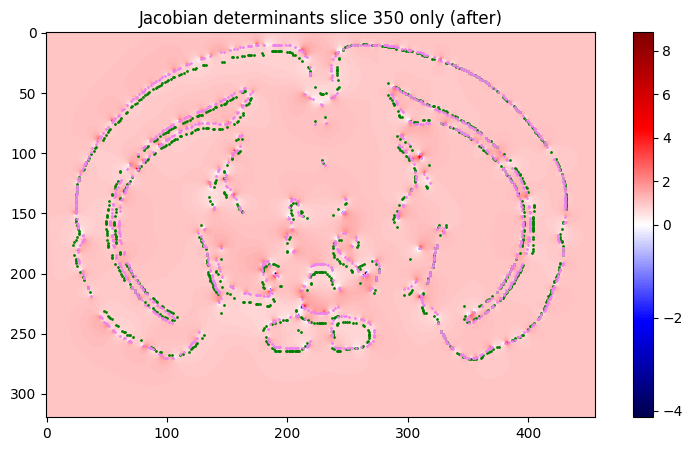

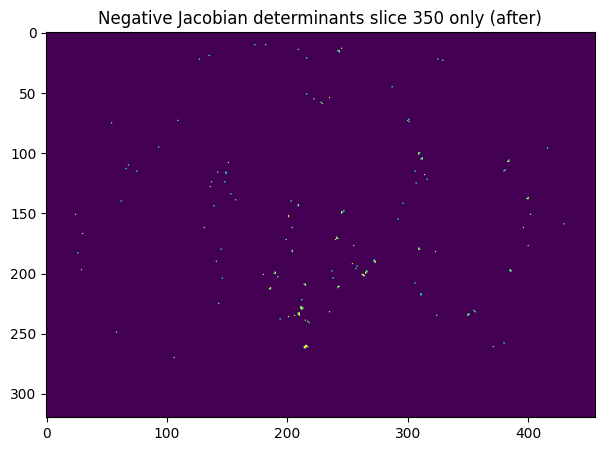

In [5]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_intersection_removed, fpoints_intersection_removed)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_intersection_removed[:, 2], mpoints_intersection_removed[:, 1], c="g", s=1)
plt.scatter(fpoints_intersection_removed[:, 2], fpoints_intersection_removed[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

## Remove ORIENTATION outliers from correspondence points

In [6]:
MAX_DIST = 30
MAX_DEG = 60

mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Number of outliers: 230 out of 1326 points
Number of outliers: 17 out of 1326 points
Number of outliers: 1 out of 1326 points
Number of outliers: 0 out of 1326 points

Number of runs: 4
Number of points removed: 248
Number of points in the corrected points: 1078 / 1326


## Compute Jacobian of orientation-filtered points

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05446481704711914s
Computing dy
dy calculated in 0.1712510585784912s
Computing dx
dx calculated in 0.26940178871154785s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04647660255432129s
Computing dy
dy calculated in 0.20041966438293457s
Computing dx
dx calculated in 0.31714463233947754s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 177
After - minimum Jacobian determinant: -3.705544075115345
After - maximum Jacobian determinant: 6.613283330845526


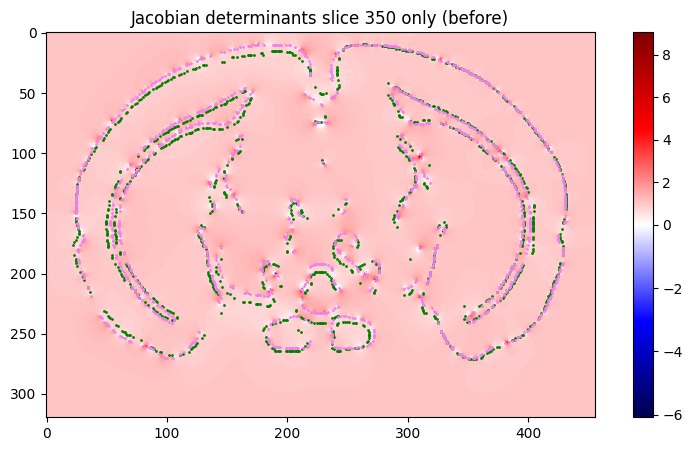

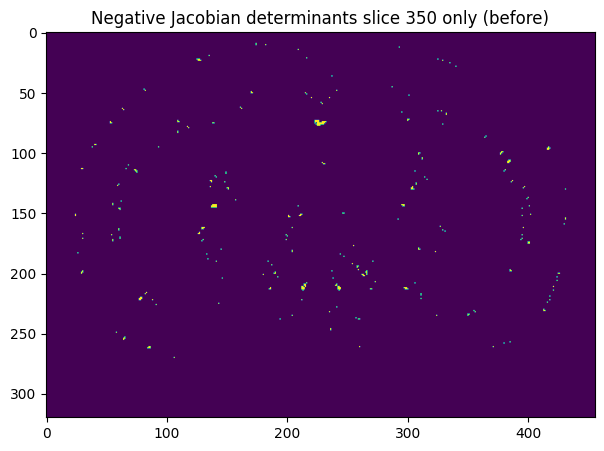

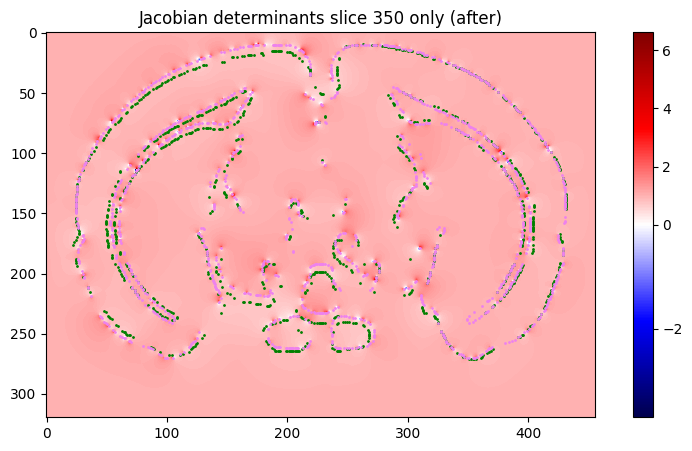

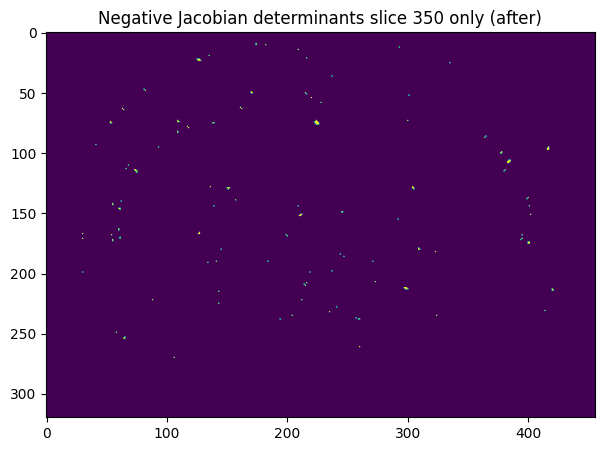

In [7]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___

## Remove MAGNITUDE outliers

In [8]:
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Point 50 has a larger relative magnitude of 4.47213595499958 > 3.207213595499958 (1.2072135954999579).
Point 68 has a larger relative magnitude of 5.0 > 4.9799953278137 (2.979995327813701).
Point 72 has a larger relative magnitude of 5.830951894845301 > 5.021324625053363 (3.0213246250533627).
Point 79 has a larger relative magnitude of 9.219544457292887 > 7.8918708441517404 (5.261247229434494).
Point 81 has a larger relative magnitude of 9.219544457292887 > 7.8918708441517404 (5.261247229434494).
Point 88 has a larger relative magnitude of 6.0 > 3.824160450111475 (1.824160450111475).
Point 91 has a larger relative magnitude of 4.47213595499958 > 3.718897292216738 (1.718897292216738).
Point 94 has a larger relative magnitude of 4.47213595499958 > 3.3829524276059013 (1.3829524276059013).
Point 119 has a smaller relative magnitude of 0.0 < 3.1505101394170643 (5.150510139417064).
Point 125 has a smaller relative magnitude of 0.0 < 3.3169458057417165 (5.3169458057417165).
Point 128 has a sm

## Compute Jacobian of magnitude-filtered points

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05011153221130371s
Computing dy
dy calculated in 0.16422343254089355s
Computing dx
dx calculated in 0.25794458389282227s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04549384117126465s
Computing dy
dy calculated in 0.1645197868347168s
Computing dx
dx calculated in 0.2658684253692627s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 204
After - minimum Jacobian determinant: -3.9731419957669822
After - maximum Jacobian determinant: 7.441483621937265


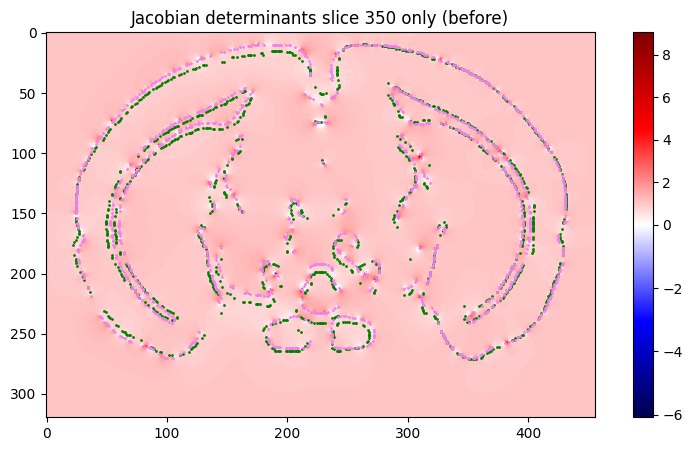

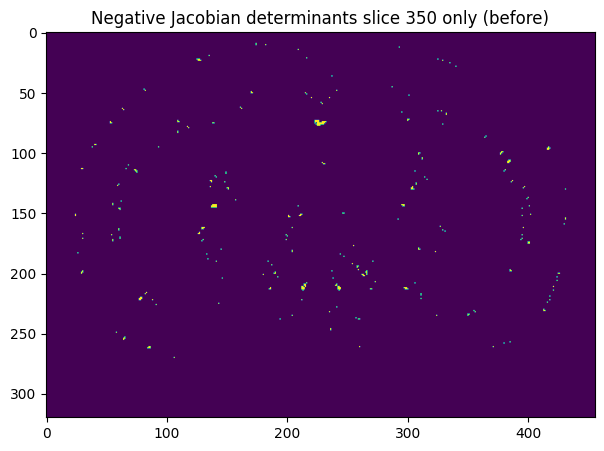

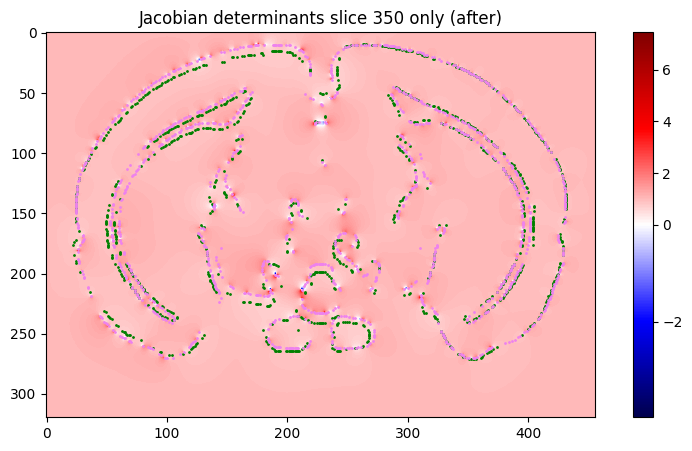

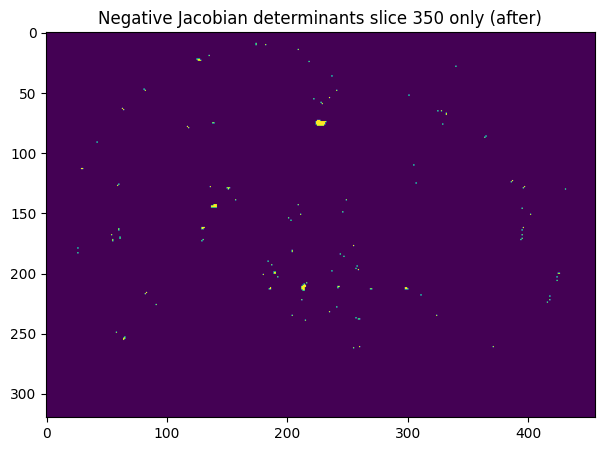

In [9]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___
# Combine all

In [10]:
def get_negative_jdet_stats(jdet: np.ndarray, debug: bool = False) -> tuple:
    """
    Get the average, median, and standard deviation of the negative Jacobian determinants.
    
    Parameters:
    jdet (np.ndarray): The Jacobian determinant field.
    
    Returns:
    Tuple[float, float, float]: The average, median, standard deviation, min, and max of the negative Jacobian determinants.
    """
    negative_jdet = jdet[jdet <= 0]
    jdet_mean = np.mean(negative_jdet)
    jdet_median = np.median(negative_jdet)
    jdet_std = np.std(negative_jdet)
    jdet_min = negative_jdet.min()
    jdet_max = negative_jdet.max()
    if debug:
        print("Number of negative Jacobian determinants:", len(negative_jdet))
        print("Average negative Jacobian determinant:", jdet_mean)
        print("Median negative Jacobian determinant:", jdet_median)
        print("Standard deviation of negative Jacobian determinants:", jdet_std)
        print("Minimum negative Jacobian determinant:", jdet_min)
        print("Maximum negative Jacobian determinant:", jdet_max)
    return jdet_mean, jdet_median, jdet_std, jdet_min, jdet_max

### Run intersection removal

In [11]:
# Start with intersecting point removal
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
curr_mpoints = mpoints_intersection_removed.copy()
curr_fpoints = fpoints_intersection_removed.copy()
curr_cvectors = curr_fpoints - curr_mpoints

print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

Starting number of correspondences: 1326
Number of correspondences after removing intersections: 1246
Number of correspondences removed: 80


fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.051686763763427734s
Computing dy
dy calculated in 0.16350293159484863s
Computing dx
dx calculated in 0.2580392360687256s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04678463935852051s
Computing dy
dy calculated in 0.1677839756011963s
Computing dx
dx calculated in 0.26734066009521484s
SITK deformation shape: (1, 320, 456, 3)

Base Jdet before modifications:
Number of negative Jacobian determinants: 386
Average negative Jacobian determinant: -0.5640707394702855
Median negative Jacobian determinant: -0.31449281575664245
Standard deviation of negative Jacobian determinants: 0.7454131492787323
Minimum negative Jacobian determinant: -6.08035232834211
Maximum negative Jacobian determinant: -0.00046179012442182366


Before - nu

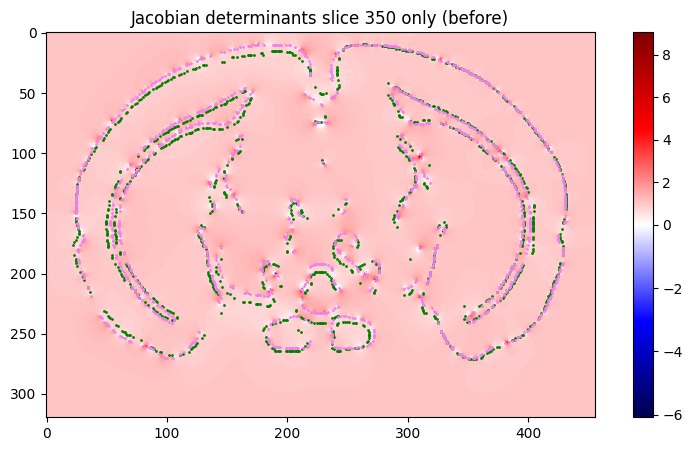

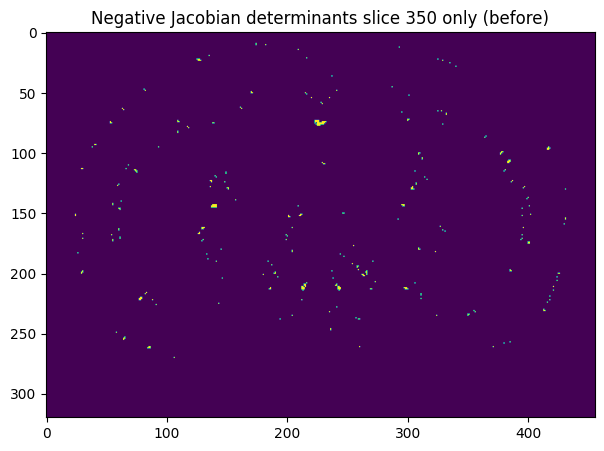

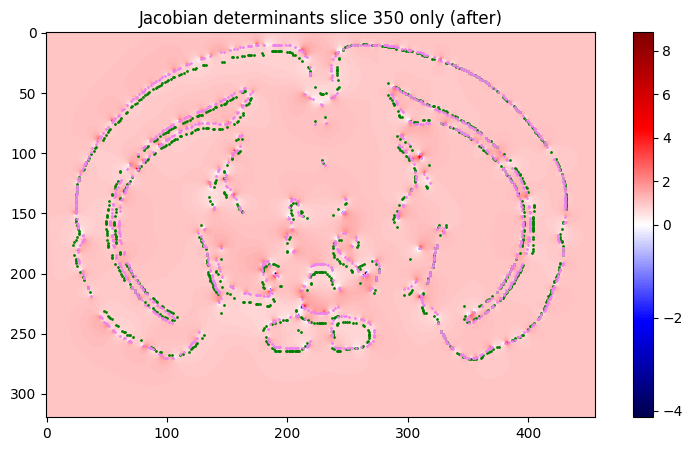

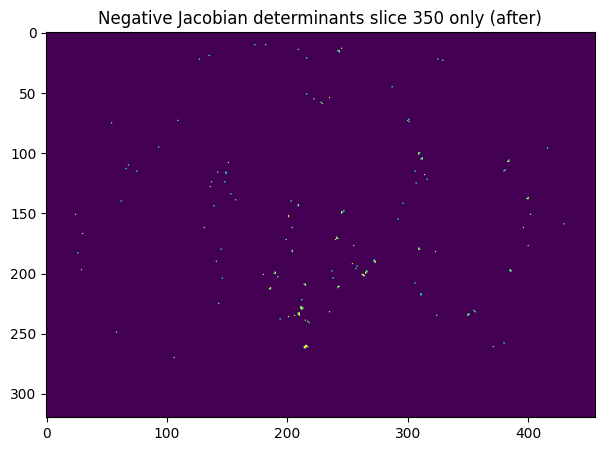

In [12]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

print("\nBase Jdet before modifications:")
get_negative_jdet_stats(jdet, debug=True)
print()

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print()

get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

### Run orientation removal

In [13]:
# Now remove orientation outliers
MAX_DIST = 30
MAX_DEG = 60  # 60 default

mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(curr_fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Number of outliers: 184 out of 1246 points
Number of outliers: 18 out of 1246 points
Number of outliers: 7 out of 1246 points
Number of outliers: 2 out of 1246 points
Number of outliers: 1 out of 1246 points
Number of outliers: 0 out of 1246 points

Number of runs: 6
Number of points removed: 212
Number of points in the corrected points: 1034 / 1246


### Check intermediary Jacobian

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05187582969665527s
Computing dy
dy calculated in 0.1690380573272705s
Computing dx
dx calculated in 0.27117204666137695s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04728198051452637s
Computing dy
dy calculated in 0.18793082237243652s
Computing dx
dx calculated in 0.29880738258361816s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 92
After - minimum Jacobian determinant: -3.473978516992518
After - maximum Jacobian determinant: 5.79103541966788

Number of negative Jacobian determinants: 92
Avera

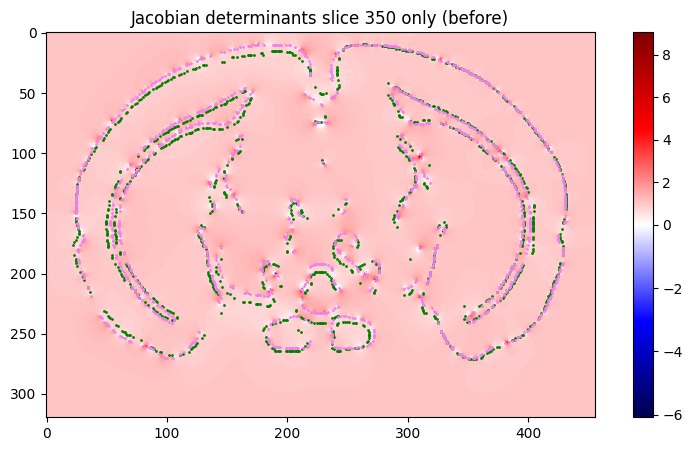

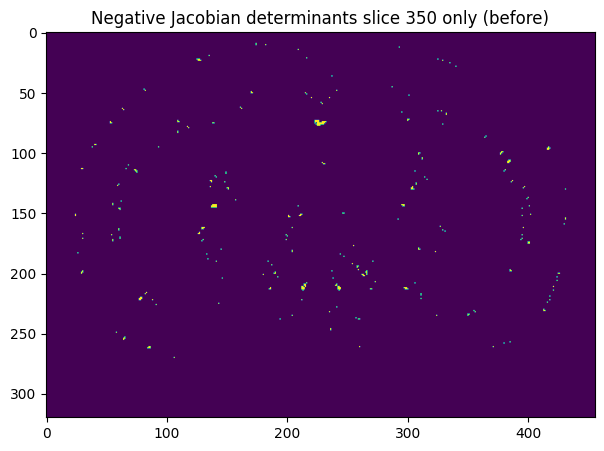

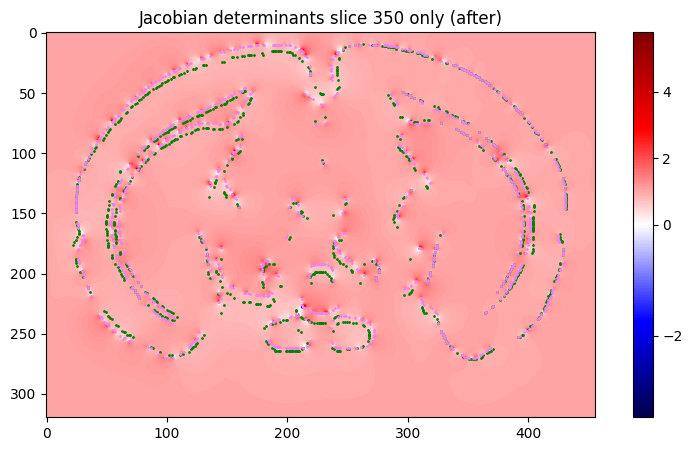

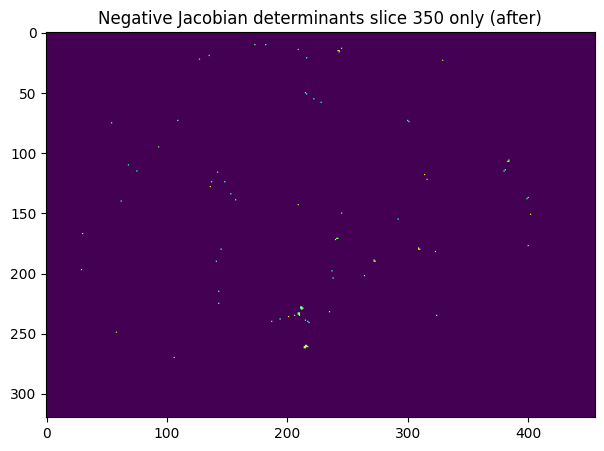

In [14]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print() 

get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

### Run magnitude removal

In [15]:
# Now run magnitude
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\n\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Point 33 has a smaller relative magnitude of 0.0 < 1.1765306226698662 (2.3530612453397324).
Point 47 has a larger relative magnitude of 7.211102550927978 > 5.236923245394814 (3.236923245394814).
Point 48 has a larger relative magnitude of 3.605551275463989 > 3.1630286277012187 (1.163028627701219).
Point 61 has a smaller relative magnitude of 0.0 < 1.4200713635801094 (2.840142727160219).
Point 65 has a larger relative magnitude of 5.830951894845301 > 5.308412907387316 (3.3084129073873156).
Point 72 has a larger relative magnitude of 9.219544457292887 > 7.725952270616403 (5.150634847077602).
Point 74 has a larger relative magnitude of 9.219544457292887 > 7.725952270616403 (5.150634847077602).
Point 80 has a larger relative magnitude of 4.47213595499958 > 3.0476517761412576 (1.0476517761412576).
Point 105 has a smaller relative magnitude of 0.0 < 2.9985639364982966 (4.998563936498297).
Point 110 has a smaller relative magnitude of 0.0 < 3.162296223352196 (5.162296223352196).
Point 112 has

In [16]:
print("Final number of correspondences:", curr_mpoints.shape[0])

Final number of correspondences: 892


## Compute Jacobian of final combined operation

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.0512995719909668s
Computing dy
dy calculated in 0.16543221473693848s
Computing dx
dx calculated in 0.2604846954345703s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04665207862854004s
Computing dy
dy calculated in 0.189589262008667s
Computing dx
dx calculated in 0.31400084495544434s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 27
After - minimum Jacobian determinant: -0.8647245957286207
After - maximum Jacobian determinant: 3.9868281439344906

Number of negative Jacobian determinants: 27
Avera

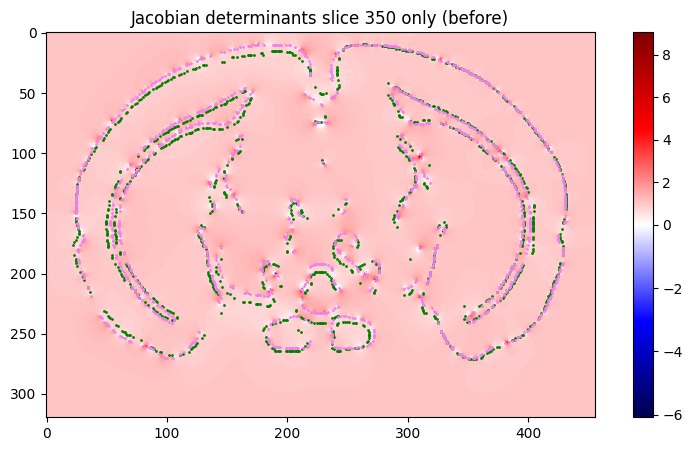

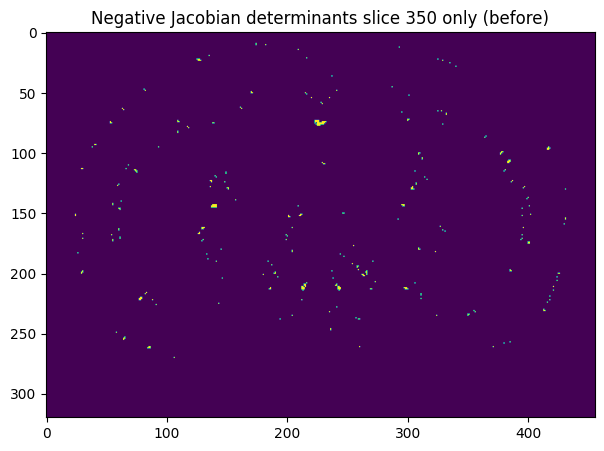

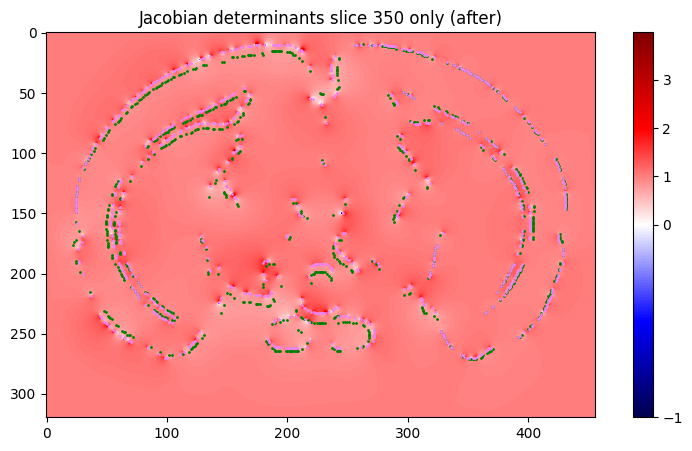

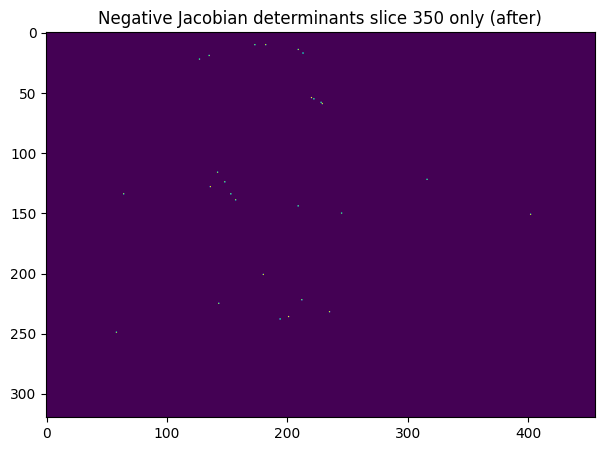

In [17]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print()

get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

In [18]:
# Save the final corrected correspondences
#np.save("output/mpoints_27.npy", curr_mpoints)
#np.save("output/fpoints_27.npy", curr_fpoints)
#np.save("output/deformation_27.npy", deformation_corrected)
#np.save("output/jdet_27.npy", jdet_corrected)

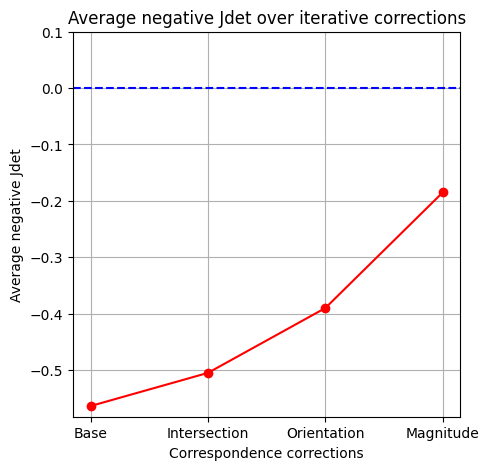

In [19]:
# Plot average negative Jdets (overall severity)

# Values to plot
values = [-0.56407, -0.50526, -0.39018, -0.18502]

f = plt.figure(figsize=(5, 5))

# Create a line plot
plt.plot(values, marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Correspondence corrections')
plt.xticks([0, 1, 2, 3], ['Base', 'Intersection', 'Orientation', 'Magnitude'])
plt.ylabel('Average negative Jdet')
plt.ylim(top=0.1)
plt.title('Average negative Jdet over iterative corrections')

# Draw a horizontal line at y = 0
plt.axhline(y=0, color='b', linestyle='--')

# Show the plot
plt.grid(True)
plt.show()
f.clear()
plt.close(f)

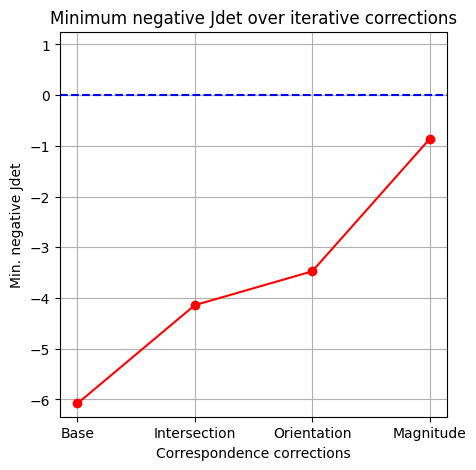

In [20]:
# Plot minimum Jdet values (worst case)

# Values to plot
values = [-6.08035, -4.14126, -3.47397, -0.86472]

f = plt.figure(figsize=(5, 5))

# Create a line plot
plt.plot(values, marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Correspondence corrections')
plt.xticks([0, 1, 2, 3], ['Base', 'Intersection', 'Orientation', 'Magnitude'])
plt.ylabel('Min. negative Jdet')
plt.ylim(top=1.25)
plt.title('Minimum negative Jdet over iterative corrections')

# Draw a horizontal line at y = 0
plt.axhline(y=0, color='b', linestyle='--')

# Show the plot
plt.grid(True)
plt.show()
f.clear()
plt.close(f)

___
# Run analysis on output

In [21]:
def get_negative_jdet_coords(jdet: np.ndarray) -> np.ndarray:
    """
    Get the coordinates of the negative Jacobian determinants.
    
    Parameters:
    jdet (np.ndarray): The Jacobian determinant field.
    
    Returns:
    np.ndarray: The coordinates of the negative Jacobian determinants.
    """
    return np.argwhere(jdet <= 0)


import matplotlib.patheffects as path_effects


def show_point(coord: np.ndarray, deformation: np.ndarray, jdet: np.ndarray, fpoints: np.ndarray=None, n: int=5):
    """
    Shows a plot of n x n points around a coordinate.
    
    Parameters:
    coord (np.ndarray): The coordinate.
    deformation (np.ndarray): The deformation field.
    jdet (np.ndarray): The Jacobian determinant field.
    fpoints (np.ndarray): The fixed points (optional).
    n (int): The size of the grid centering the current coordinate. Should be an odd number, otherwise size is increased + 1.
    """
    # Get the n x n points around the coordinate
    z, y, x = coord
    y_min = max(y - (n // 2), 0)
    y_max = min(y + (n // 2), jdet.shape[1])
    x_min = max(x - (n // 2), 0)
    x_max = min(x + (n // 2), jdet.shape[2])
    
    # Get only fpoints from the current slice if any are provided
    if fpoints is not None:
        fpoints = fpoints[fpoints[:, 0] == coord[0]]
    
    # Adjust font size based on n
    font_size = max(8, 16 - n)
    
    # Normalize the colorbar for the Jacobian determinant field
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
    
    # Subplot 1: Plot the Jacobian determinant field
    gridspec = {'width_ratios': [1, 1, 0.1]}
    fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec)
    im = ax[0].imshow(jdet[0], cmap="seismic", norm=norm, interpolation='nearest')
    ax[0].set_xlim(x_min - 0.5, x_max + 0.5)
    ax[0].set_ylim(y_max + 0.5, y_min - 0.5)
    ax[0].set_title(f"Jacobian determinant field\n{tuple(coord)}")
    
    # Write the jacobian determinant values on the plot
    for j in range(y_min, y_max + 1):
        for i in range(x_min, x_max + 1):
            is_negative_jdet = (jdet[0, j, i] <= 0)
            if is_negative_jdet:
                text_color = 'blue'
                text_weight = 'bold'
            else:
                text_color = 'black'
                text_weight = 'normal'
            t = ax[0].text(i, j, f"{jdet[0, j, i]:.2f}", ha='center', va='center', color=text_color, fontsize=font_size, weight=text_weight)
            if is_negative_jdet:
                t.set_path_effects([path_effects.Stroke(linewidth=1, foreground="white"), path_effects.Normal()])
    
    # Subplot 2: Plot the displacement vector field
    ax[1].imshow(jdet[0], cmap="seismic", norm=norm, interpolation='nearest')
    for j in range(y_min, y_max + 1):
        for i in range(x_min, x_max + 1):
            y_displacement = deformation[2][0][j][i]
            x_displacement = deformation[1][0][j][i]
            
            # Adjust the magnitude for visual clarity
            magnitude = np.sqrt(y_displacement**2 + x_displacement**2) * 2
            adjusted_y_displacement = y_displacement
            adjusted_x_displacement = x_displacement
            if magnitude != 0:
                adjusted_y_displacement /= magnitude
                adjusted_x_displacement /= magnitude
                
            # If the point is a correspondence, color green, otherwise make it black
            is_correspondence = fpoints is not None and any(np.array_equal((coord[0], j, i), arr) for arr in fpoints)
            if is_correspondence: 
                arrow_color = 'green'
            else:
                arrow_color = 'black'
                
            # Plot the displacement vector
            ax[1].annotate(
                '', 
                xy=(i + adjusted_x_displacement, j + adjusted_y_displacement), 
                xytext=(i, j), 
                arrowprops=dict(color=arrow_color, shrink=0.045, headwidth=4, headlength=4.5, width=0.75)
            )
            
            # Color based on Jacobian determinant value
            is_negative_jdet = (jdet[0, j, i] <= 0)
            if is_negative_jdet:  # If the Jacobian determinant is negative, color blue/bold
                text_color = 'blue'
                text_weight = 'bold'
            elif is_correspondence:  # If the point is a correspondence, color green/bold
                text_color = 'green'
                text_weight = 'bold'
            else:  # If the Jacobian determinant is positive, color black/normal
                text_color = 'black'
                text_weight = 'normal'
            # Set text of displacement vector
            t = ax[1].text(i, j, f"{round(y_displacement, 2)}\n\n{round(x_displacement, 2)}", ha='center', va='center', color=text_color, weight=text_weight, fontsize=font_size)
            if is_negative_jdet:
                t.set_path_effects([path_effects.Stroke(linewidth=1, foreground="white"), path_effects.Normal()])


    # Ensure x and y axes show integer coordinates
    ax[1].set_xlim(x_min - 0.5, x_max + 0.5)
    ax[1].set_ylim(y_max + 0.5, y_min - 0.5)
    ax[1].set_title(f"Displacement field\n{tuple(coord)}")
    for axis in ax:
        axis.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        axis.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
       
    # Create a colorbar for the Jacobian determinant field
    cax = ax[2]
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    plt.show()

    # Clear from memory
    fig.clear()
    plt.close(fig)

## Try specific indices

In [22]:
jdet_idx = 0

for i in range(0):
    jdet_idx = i
    print("JDET INDEX:", jdet_idx)
    # Get the coordinates of the negative Jacobian determinants
    negative_jdet_coords = get_negative_jdet_coords(jdet_corrected)
    for coord in negative_jdet_coords:
        coord = tuple(coord)
        info_str = str(coord) + " " + str(jdet_corrected[coord])
        print(info_str)
    print()
    print("Current Jdet coordinate index:", jdet_idx)
    print("Number of negative Jdet coords:", len(negative_jdet_coords))


    # Analyze a sample negative Jacobian determinant coordinate
    sample_coord = negative_jdet_coords[jdet_idx]
    print("Negative Jacobian determinant coordinate:", sample_coord)
    jacobian.surrounding_points(sample_coord, deformation_corrected, jdet_corrected)
    show_point(sample_coord, deformation_corrected, jdet_corrected, fpoints=fpoints_corrected, n=9)
    print()
    print()

# Grid

In [193]:
import networkx as nx

## Load correspondences with intersections removed already

In [194]:
CURR_IDX = 350  # Only consider the correspondences of this index

# Input parameters
base_path = "data/corrected_correspondences_count_touching/registered_output/deformation3d.npy"
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]

# Change the 0th index in each element to 0
mpoints[:, 0] = 0
fpoints[:, 0] = 0

cvectors = fpoints - mpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("First five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

Correspondence point shape: (1246, 3)
First five fixed points:
 [[  0.  10. 175.]
 [  0.  10. 174.]
 [  0.  10. 176.]
 [  0.  10. 181.]
 [  0.  10. 188.]]
First five moving points:
 [[  0.  17. 179.]
 [  0.  18. 172.]
 [  0.  18. 180.]
 [  0.  15. 187.]
 [  0.  15. 188.]]
First five correspondence vectors:
 [[ 0. -7. -4.]
 [ 0. -8.  2.]
 [ 0. -8. -4.]
 [ 0. -5. -6.]
 [ 0. -5.  0.]]


## Check grid neighborhood (orientation)

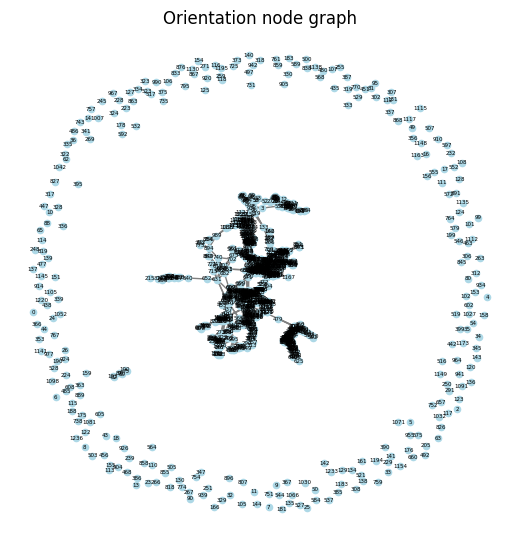

In [284]:
# Go through every correspondence and get neighboring correspondences within a grid radius
# Now remove orientation outliers
MAX_DIST = 30 # np.sqrt(50)
MAX_DEG = 60  # 60 default

mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()

orientation_graph = nx.Graph()
orientation_graph.add_nodes_from(range(len(fpoints_corrected)))

for i in range(len(fpoints_corrected)):
    curr_point = fpoints_corrected[i]
    curr_vector = cvectors_corrected[i]
    #print("Current point:", curr_point)
    neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)
    #print("Number of neighbors:", len(neighborhood_idx))
    #print(neighborhood_idx)
    #print(neighborhood)
    
    # Check orientation 
    # Compute the average correspondence vector in the neighborhood
    #average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
    for j in range(len(neighborhood_idx)):
        nidx = neighborhood_idx[j]
        neighborhood_point = fpoints_corrected[nidx]
        neighborhood_vector = cvectors_corrected[nidx]
        angle_rad, angle_deg = angle_between_vectors(curr_vector, neighborhood_vector)
        if angle_deg > MAX_DEG:
            orientation_graph.add_edge(i, nidx)
            
# Adjust the layout to bring nodes closer together
pos = nx.spring_layout(orientation_graph)

# Visualize the graph
plt.figure(figsize=(5, 5))
nx.draw(orientation_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=20, font_size=4)
plt.title("Orientation node graph")
plt.show()

Orientation graph
Number of nodes: 136
Top ten nodes and their degrees:
	Node 960: 52
	Node 945: 46
	Node 959: 46
	Node 929: 44
	Node 288: 39
	Node 673: 39
	Node 1177: 39
	Node 1114: 37
	Node 1137: 37
	Node 1139: 37


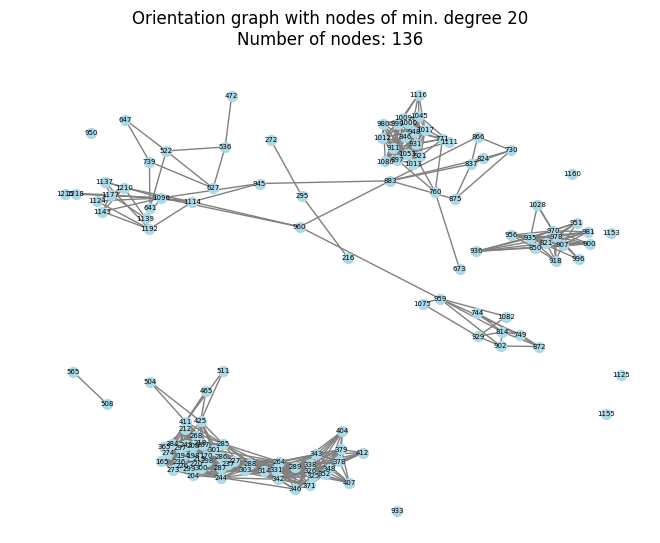

In [285]:
MIN_DEGREE = 20

# Get information about degree of each node
degree_dict = dict(orientation_graph.degree())
sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)

# Filter nodes with degrees above MIN_DEGREE
filtered_nodes = [node for node, degree in degree_dict.items() if degree >= MIN_DEGREE]
filtered_G = orientation_graph.subgraph(filtered_nodes)  # Create a subgraph with the filtered nodes

# Print information
print("Orientation graph")
print("Number of nodes:", len(filtered_G.nodes))
print("Top ten nodes and their degrees:")
for node in sorted_nodes[:10]:
    print(f"\tNode {node}: {degree_dict[node]}")

# Draw the filtered graph
pos = nx.spring_layout(filtered_G, k=0.5, iterations=100)
nx.draw(filtered_G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=50, font_size=5)
plt.title(f"Orientation graph with nodes of min. degree {MIN_DEGREE}\nNumber of nodes: {len(filtered_G.nodes)}")
plt.show()

In [286]:
print(f"\tNode {212}: {degree_dict[212]}")

	Node 212: 21


In [287]:
# Degree centrality
degree_centrality = nx.degree_centrality(orientation_graph)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top ten nodes and their degree centrality:")
for node, centrality in sorted_degree_centrality[:10]:
    print(f"\tNode {node}: {centrality}")
print()
    
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(orientation_graph)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top ten nodes and their betweenness centrality:")
for node, centrality in sorted_betweenness_centrality[:10]:
    print(f"\tNode {node}: {centrality}")
print()

# Closeness centrality
closeness_centrality = nx.closeness_centrality(orientation_graph)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top ten nodes and their closeness centrality:")
for node, centrality in sorted_closeness_centrality[:10]:
    print(f"\tNode {node}: {centrality}")

Top ten nodes and their degree centrality:
	Node 960: 0.04176706827309237
	Node 945: 0.036947791164658635
	Node 959: 0.036947791164658635
	Node 929: 0.03534136546184739
	Node 288: 0.03132530120481928
	Node 673: 0.03132530120481928
	Node 1177: 0.03132530120481928
	Node 1114: 0.029718875502008035
	Node 1137: 0.029718875502008035
	Node 1139: 0.029718875502008035

Top ten nodes and their betweenness centrality:
	Node 295: 0.08729201710918529
	Node 591: 0.08340657800345265
	Node 481: 0.08224292455285084
	Node 290: 0.07703240639612581
	Node 436: 0.061632516771415936
	Node 594: 0.05305148327400946
	Node 479: 0.052640321450610844
	Node 508: 0.049564399838961104
	Node 902: 0.04078139705873474
	Node 676: 0.03945656459539295

Top ten nodes and their closeness centrality:
	Node 617: 0.062058612914396565
	Node 594: 0.06162581359922449
	Node 713: 0.061246139738004766
	Node 727: 0.061246139738004766
	Node 627: 0.060871115537542445
	Node 641: 0.060871115537542445
	Node 673: 0.06075486054224538
	Node 6

### Remove conflicts

In [288]:
top_N = 20
sorted_nodes = sorted_degree_centrality

sorted_nodes = np.array(sorted_nodes)[:, 0]
outlier_indices = np.array(sorted_nodes[:top_N]).astype(int)

# Remove outlier indices from moving and fixed points
mpoints_new = np.delete(mpoints_corrected.copy(), outlier_indices, axis=0)
fpoints_new = np.delete(fpoints_corrected.copy(), outlier_indices, axis=0)
cvectors_new = np.delete(cvectors_corrected.copy(), outlier_indices, axis=0)

print("Number of points originally:", len(mpoints_corrected))
print("Number of points after removal:", len(mpoints_new))

Number of points originally: 1246
Number of points after removal: 1226


In [289]:
# Plot number of Jdets over time with number of nodes removed
num_neg_Jdets = []
fixed_resolution = np.zeros((1, 320, 456))
jdet_mean_list = []
jdet_median_list = []
jdet_std_list = []
jdet_min_list = []
jdet_max_list = []

N_to_remove = range(0, len(sorted_degree_centrality), 20)
for N in N_to_remove:
    sorted_nodes = sorted_degree_centrality

    sorted_nodes = np.array(sorted_nodes)[:, 0]
    outlier_indices = np.array(sorted_nodes[:N]).astype(int)

    # Remove outlier indices from moving and fixed points
    mpoints_new = np.delete(mpoints_corrected.copy(), outlier_indices, axis=0)
    fpoints_new = np.delete(fpoints_corrected.copy(), outlier_indices, axis=0)
    cvectors_new = np.delete(cvectors_corrected.copy(), outlier_indices, axis=0)

    deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_new, fpoints_new)
    jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)
    neg_jdet_count = np.sum(jdet_corrected <= 0)
    num_neg_Jdets.append(neg_jdet_count)
    
    if neg_jdet_count > 0:
        jdet_mean, jdet_median, jdet_std, jdet_min, jdet_max = get_negative_jdet_stats(jdet_corrected, debug=False)
    else: 
        jdet_mean, jdet_median, jdet_std, jdet_min, jdet_max = (0, 0, 0, 0, 0)
    jdet_mean_list.append(jdet_mean)
    jdet_median_list.append(jdet_median)
    jdet_std_list.append(jdet_std)
    jdet_min_list.append(jdet_min)
    jdet_max_list.append(jdet_max)

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.12794041633605957s
Computing dy
dy calculated in 0.2509944438934326s
Computing dx
dx calculated in 0.3490016460418701s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.12908101081848145s
Computing dy
dy calculated in 0.2553520202636719s
Computing dx
dx calculated in 0.35415077209472656s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.12779951095581055s
Computing dy
dy calculated in 0.25747227668762207s
Computing dx
dx calculated in 0.36580491065979004s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
C

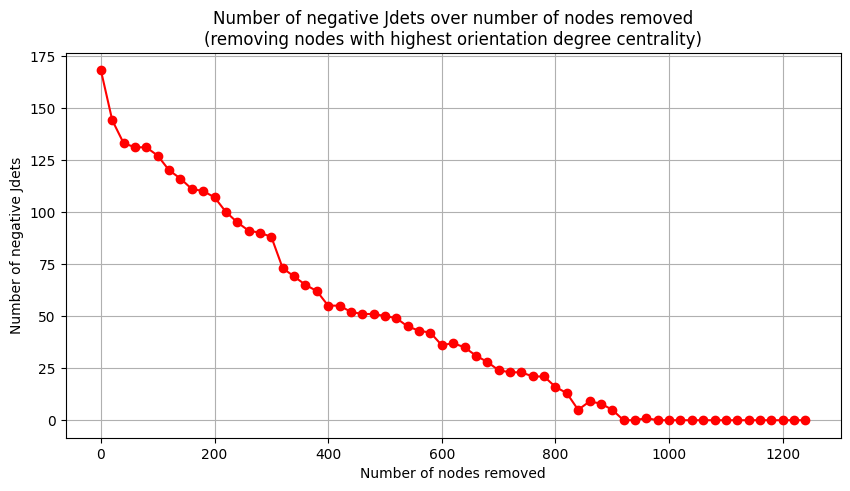

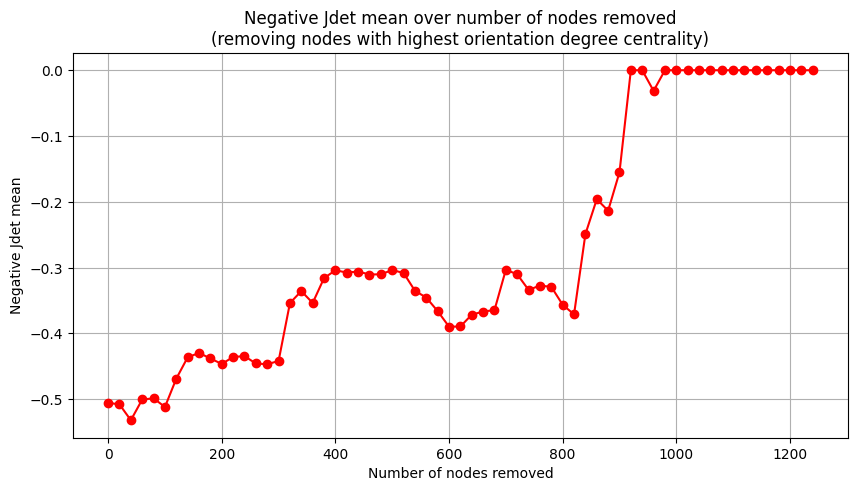

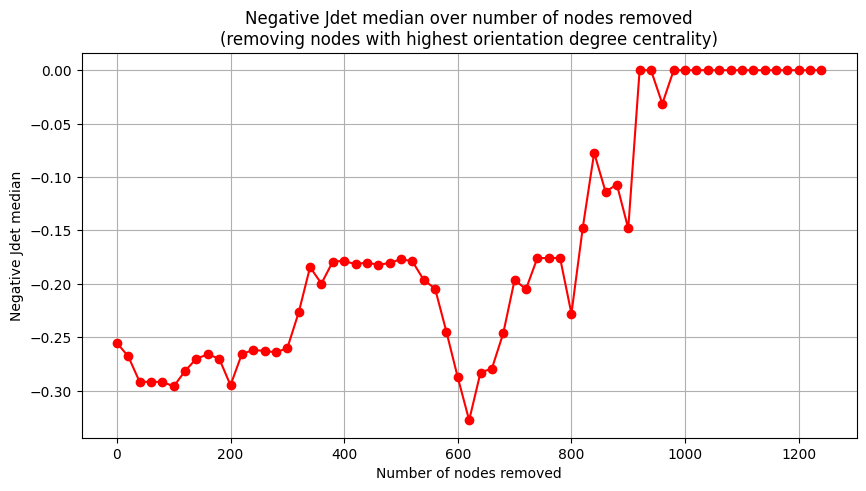

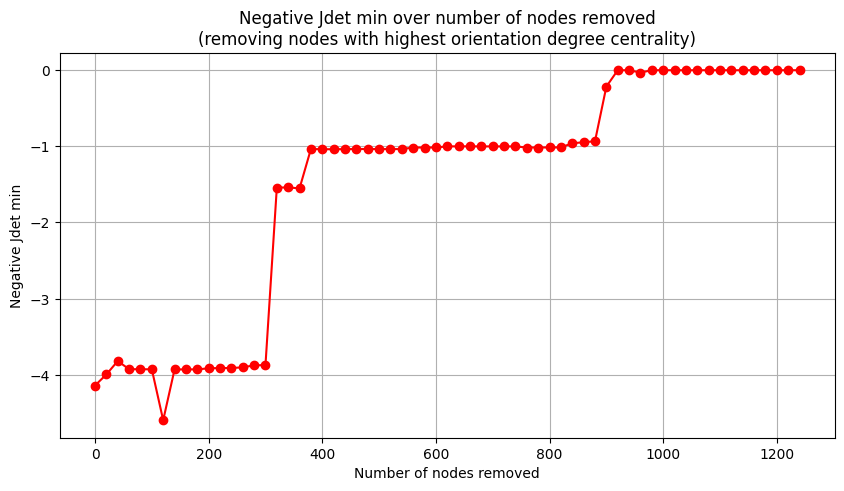

In [290]:
# Number of Jdets
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, num_neg_Jdets, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Number of negative Jdets')
plt.title('Number of negative Jdets over number of nodes removed\n(removing nodes with highest orientation degree centrality)')
plt.grid(True)
plt.show()

# Jdet mean
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, jdet_mean_list, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Negative Jdet mean')
plt.title('Negative Jdet mean over number of nodes removed\n(removing nodes with highest orientation degree centrality)')
plt.grid(True)
plt.show()

# Jdet median
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, jdet_median_list, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Negative Jdet median')
plt.title('Negative Jdet median over number of nodes removed\n(removing nodes with highest orientation degree centrality)')
plt.grid(True)
plt.show()

# Jdet min
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, jdet_min_list, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Negative Jdet min')
plt.title('Negative Jdet min over number of nodes removed\n(removing nodes with highest orientation degree centrality)')
plt.grid(True)
plt.show()

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.1317613124847412s
Computing dy
dy calculated in 0.25989341735839844s
Computing dx
dx calculated in 0.35977673530578613s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.13202667236328125s
Computing dy
dy calculated in 0.1322493553161621s
Computing dx
dx calculated in 0.13246560096740723s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 168
Before - minimum Jacobian determinant: -4.141267670622895
Before - maximum Jacobian determinant: 8.847872374160026

After - number of negative or zero Jacobian determinants: 0
After - minimum Jacobian determinant: 1.0
After - maximum Jacobian determinant: 1.0



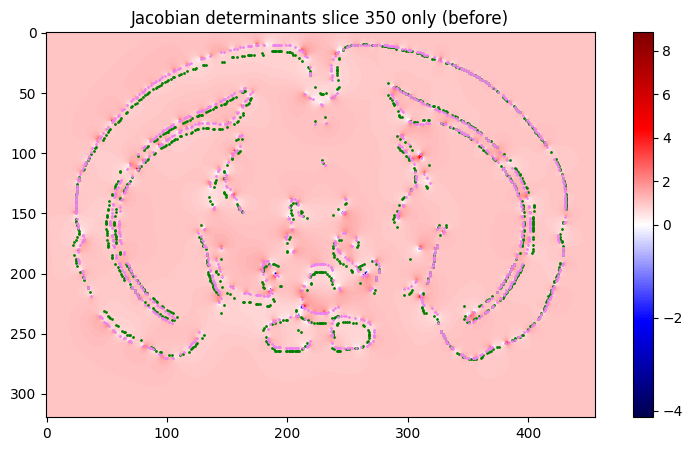

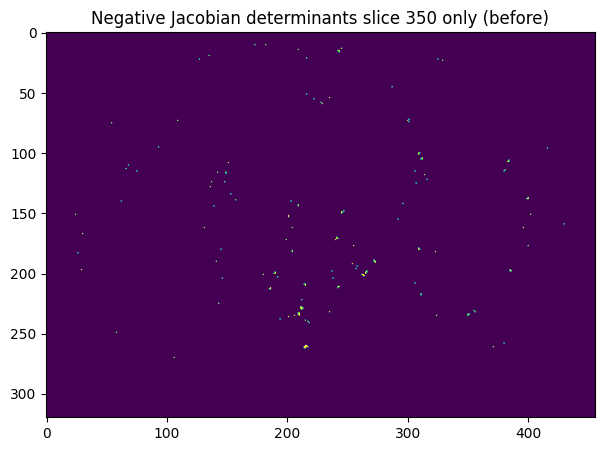

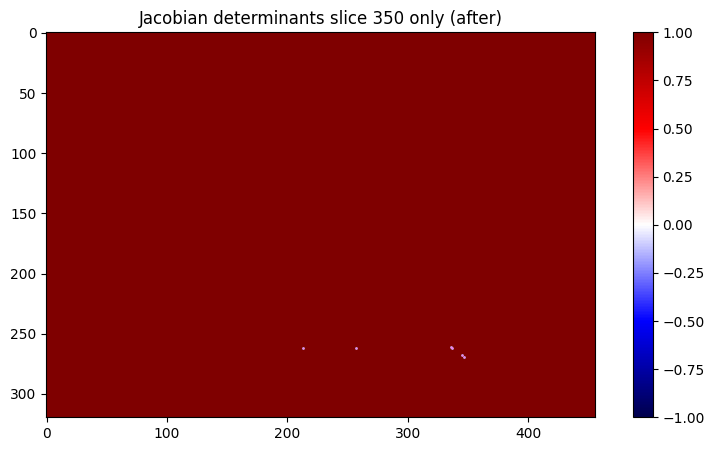

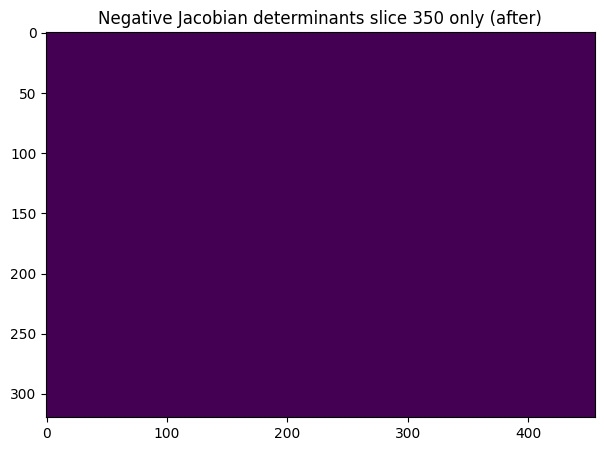

In [291]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_new, fpoints_new)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print() 

if np.sum(jdet_corrected <= 0) > 0:
    get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_new[:, 2], mpoints_new[:, 1], c="g", s=1)
plt.scatter(fpoints_new[:, 2], fpoints_new[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

## Check grid neighborhood (magnitude)

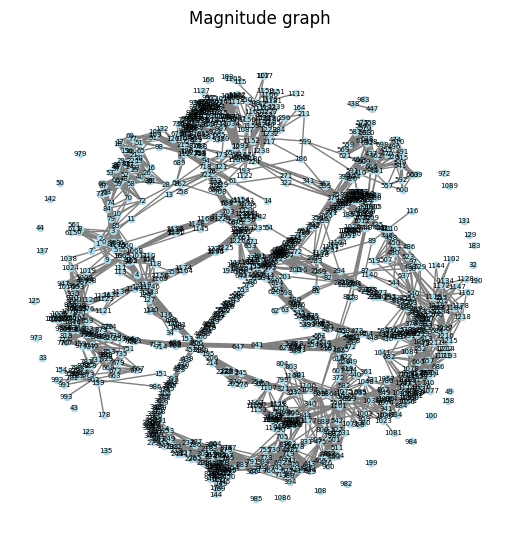

In [292]:
# Go through every correspondence and get neighboring correspondences within a grid radius
# Now remove orientation outliers
MAX_DIST = 20 # np.sqrt(50)

# Now run magnitude
MIN_MAGNITUDE_DIFF = 0.7
MAX_MAGNITUDE_DIFF = 1.3
DEBUG = False


mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

magnitude_graph = nx.Graph()
magnitude_graph.add_nodes_from(range(len(fpoints_corrected)))

for i in range(len(fpoints_corrected)):
    curr_point = fpoints_corrected[i]
    curr_magnitude = magnitudes[i]
    neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)
    
    # Check magnitude 
    for j in range(len(neighborhood_idx)):
        nidx = neighborhood_idx[j]
        neighborhood_point = fpoints_corrected[nidx]
        neighborhood_magnitude = magnitudes[nidx]
        if curr_magnitude != 0:
            magnitude_scale = neighborhood_magnitude / curr_magnitude
        else:  # If the magnitude is zero, set the scale to 1
            magnitude_scale = 1
        
        is_magnitude_valid = MIN_MAGNITUDE_DIFF < magnitude_scale < MAX_MAGNITUDE_DIFF
        if not is_magnitude_valid:
            magnitude_graph.add_edge(i, nidx)
            
# Adjust the layout to bring nodes closer together
pos = nx.spring_layout(magnitude_graph, k=0.5, iterations=250)

# Visualize the graph
plt.figure(figsize=(5, 5))
nx.draw(magnitude_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=20, font_size=5)
plt.title("Magnitude graph")
plt.show()

Magnitude graph
Number of nodes: 1213
Top ten nodes and their degrees:
	Node 897: 41
	Node 846: 38
	Node 379: 37
	Node 594: 37
	Node 690: 35
	Node 712: 34
	Node 389: 33
	Node 924: 33
	Node 261: 32
	Node 479: 32


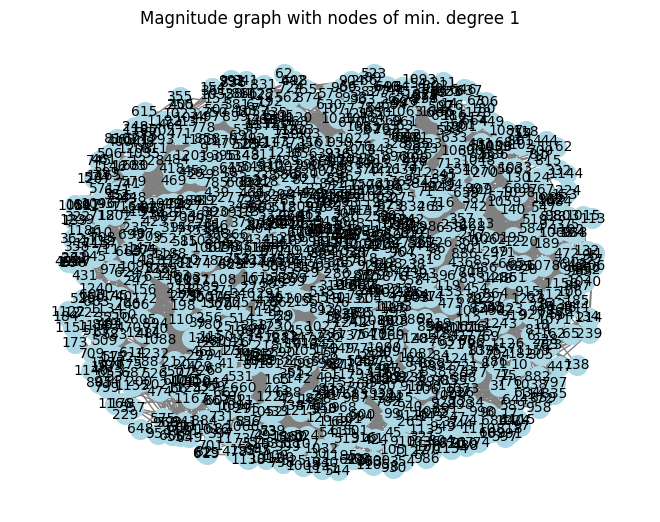

In [293]:
MIN_DEGREE = 1

# Get information about degree of each node
degree_dict = dict(magnitude_graph.degree())
sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)

# Filter nodes with degrees above MIN_DEGREE
filtered_nodes = [node for node, degree in degree_dict.items() if degree >= MIN_DEGREE]
filtered_G = magnitude_graph.subgraph(filtered_nodes)  # Create a subgraph with the filtered nodes

# Print information
print("Magnitude graph")
print("Number of nodes:", len(filtered_G.nodes))
print("Top ten nodes and their degrees:")
for node in sorted_nodes[:10]:
    print(f"\tNode {node}: {degree_dict[node]}")

# Draw the filtered graph
pos = nx.spring_layout(filtered_G, k=0.5, iterations=50)
nx.draw(filtered_G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=10)
plt.title(f"Magnitude graph with nodes of min. degree {MIN_DEGREE}")
plt.show()

In [294]:
# Degree centrality
degree_centrality = nx.degree_centrality(magnitude_graph)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top ten nodes and their degree centrality:")
for node, centrality in sorted_degree_centrality[:10]:
    print(f"\tNode {node}: {centrality}")
print()
    
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(magnitude_graph)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top ten nodes and their betweenness centrality:")
for node, centrality in sorted_betweenness_centrality[:10]:
    print(f"\tNode {node}: {centrality}")
print()

# Closeness centrality
closeness_centrality = nx.closeness_centrality(magnitude_graph)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top ten nodes and their closeness centrality:")
for node, centrality in sorted_closeness_centrality[:10]:
    print(f"\tNode {node}: {centrality}")

Top ten nodes and their degree centrality:
	Node 897: 0.03293172690763052
	Node 846: 0.030522088353413655
	Node 379: 0.029718875502008035
	Node 594: 0.029718875502008035
	Node 690: 0.02811244979919679
	Node 712: 0.027309236947791166
	Node 389: 0.026506024096385545
	Node 924: 0.026506024096385545
	Node 261: 0.02570281124497992
	Node 479: 0.02570281124497992

Top ten nodes and their betweenness centrality:
	Node 386: 0.019916658510178927
	Node 119: 0.01778667753499301
	Node 359: 0.015993609425733066
	Node 647: 0.015836565340992516
	Node 641: 0.015727518511666854
	Node 444: 0.015173597419473703
	Node 294: 0.014830203693457255
	Node 473: 0.01453777977153966
	Node 509: 0.01359099092989013
	Node 414: 0.013501838716357586

Top ten nodes and their closeness centrality:
	Node 439: 0.049623310761293345
	Node 389: 0.048948433734939754
	Node 497: 0.048714603637479856
	Node 398: 0.048637155936943316
	Node 489: 0.048444609793091606
	Node 426: 0.04798866052445074
	Node 460: 0.047913502089800074
	Node

Number of points originally: 1246
Number of points after removal: 1046
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.1272110939025879s
Computing dy
dy calculated in 0.25562405586242676s
Computing dx
dx calculated in 0.356856107711792s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.12793350219726562s
Computing dy
dy calculated in 0.25874805450439453s
Computing dx
dx calculated in 0.3622097969055176s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 168
Before - minimum Jacobian determinant: -4.141267670622895
Before - maximum Jacobian determinant: 8.847872374160026

After - number of negative or zero Jacobian determinants: 130
After - minimum Jacobian determinant: -4.1242445371392495
After - maximum Jacobian determinan

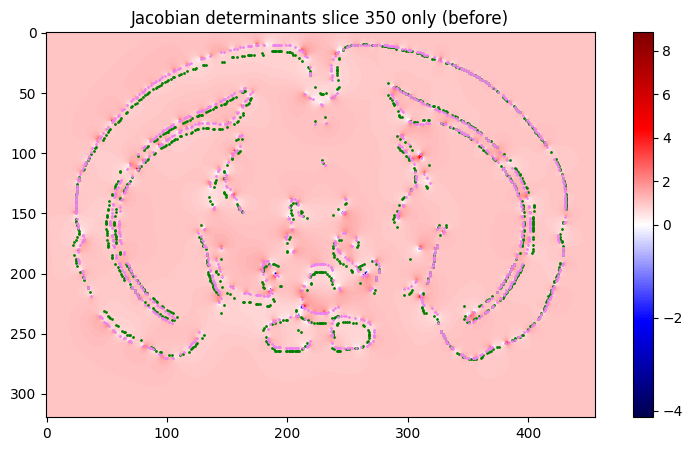

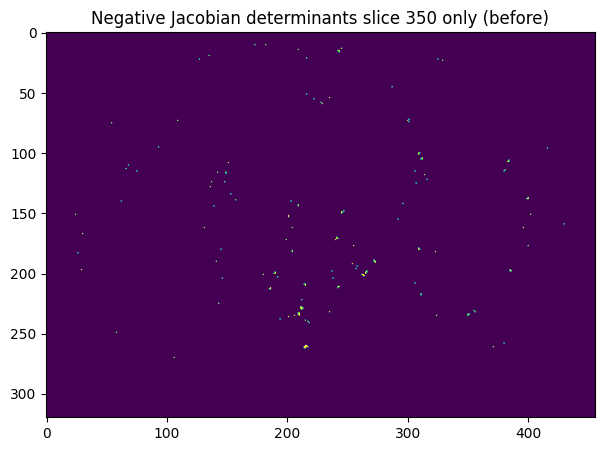

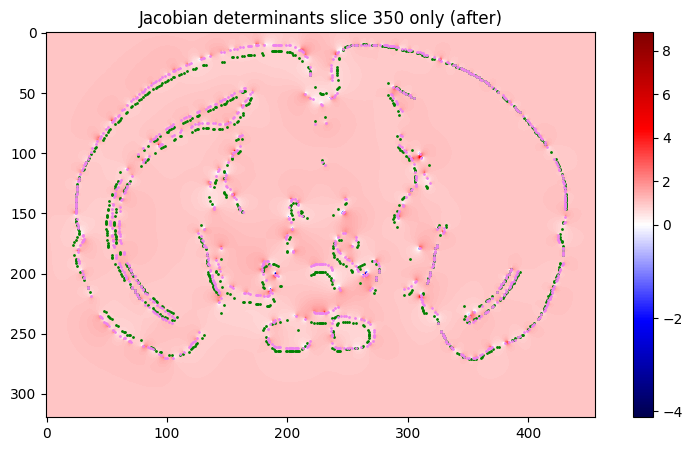

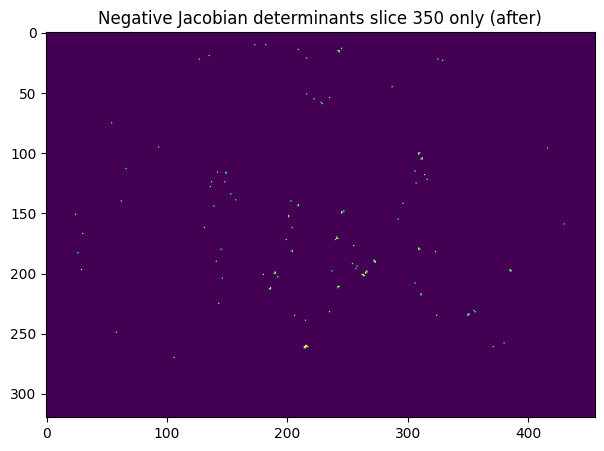

In [295]:
top_N = 200
sorted_nodes = sorted_closeness_centrality

sorted_nodes = np.array(sorted_nodes)[:, 0]
outlier_indices = np.array(sorted_nodes[:top_N]).astype(int)

# Remove outlier indices from moving and fixed points
mpoints_new = np.delete(mpoints_corrected.copy(), outlier_indices, axis=0)
fpoints_new = np.delete(fpoints_corrected.copy(), outlier_indices, axis=0)
cvectors_new = np.delete(cvectors_corrected.copy(), outlier_indices, axis=0)

print("Number of points originally:", len(mpoints_corrected))
print("Number of points after removal:", len(mpoints_new))

##############################################################################################################

fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_new, fpoints_new)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print() 

if np.sum(jdet_corrected <= 0) > 0:
    get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_new[:, 2], mpoints_new[:, 1], c="g", s=1)
plt.scatter(fpoints_new[:, 2], fpoints_new[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

In [296]:
# Plot number of Jdets over time with number of nodes removed
num_neg_Jdets = []
fixed_resolution = np.zeros((1, 320, 456))
jdet_mean_list = []
jdet_median_list = []
jdet_std_list = []
jdet_min_list = []
jdet_max_list = []

N_to_remove = range(0, len(sorted_degree_centrality), 20)
for N in N_to_remove:
    sorted_nodes = sorted_degree_centrality

    sorted_nodes = np.array(sorted_nodes)[:, 0]
    outlier_indices = np.array(sorted_nodes[:N]).astype(int)

    # Remove outlier indices from moving and fixed points
    mpoints_new = np.delete(mpoints_corrected.copy(), outlier_indices, axis=0)
    fpoints_new = np.delete(fpoints_corrected.copy(), outlier_indices, axis=0)
    cvectors_new = np.delete(cvectors_corrected.copy(), outlier_indices, axis=0)

    deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_new, fpoints_new)
    jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)
    neg_jdet_count = np.sum(jdet_corrected <= 0)
    num_neg_Jdets.append(neg_jdet_count)
    
    if neg_jdet_count > 0:
        jdet_mean, jdet_median, jdet_std, jdet_min, jdet_max = get_negative_jdet_stats(jdet_corrected, debug=False)
    else: 
        jdet_mean, jdet_median, jdet_std, jdet_min, jdet_max = (0, 0, 0, 0, 0)
    jdet_mean_list.append(jdet_mean)
    jdet_median_list.append(jdet_median)
    jdet_std_list.append(jdet_std)
    jdet_min_list.append(jdet_min)
    jdet_max_list.append(jdet_max)

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.13067364692687988s
Computing dy
dy calculated in 0.25176477432250977s
Computing dx
dx calculated in 0.3491976261138916s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.1270911693572998s
Computing dy
dy calculated in 0.24904584884643555s
Computing dx
dx calculated in 0.3502945899963379s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.12897920608520508s
Computing dy
dy calculated in 0.25460338592529297s
Computing dx
dx calculated in 0.3581244945526123s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Co

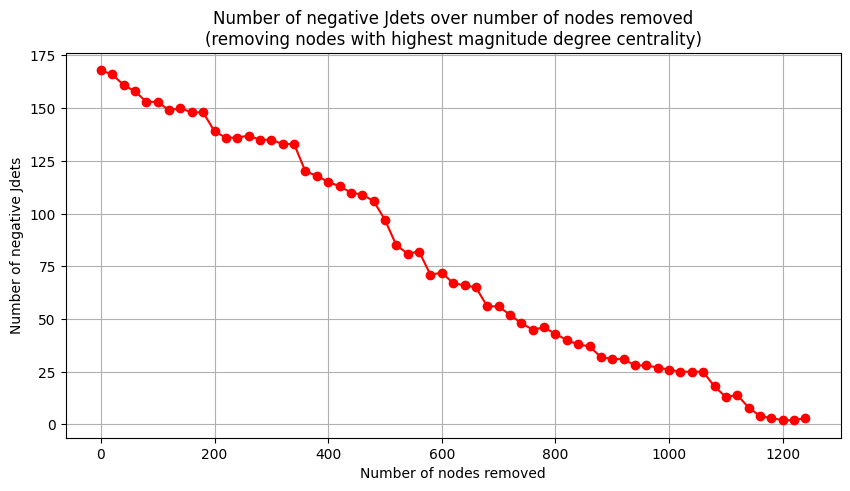

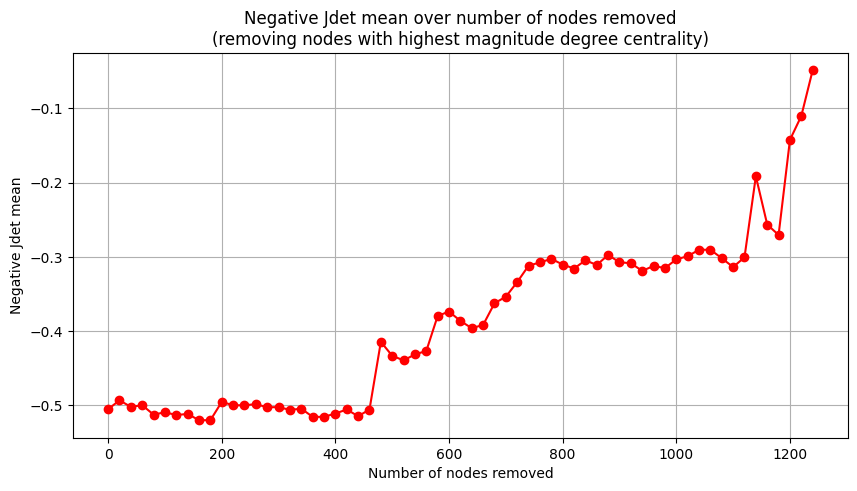

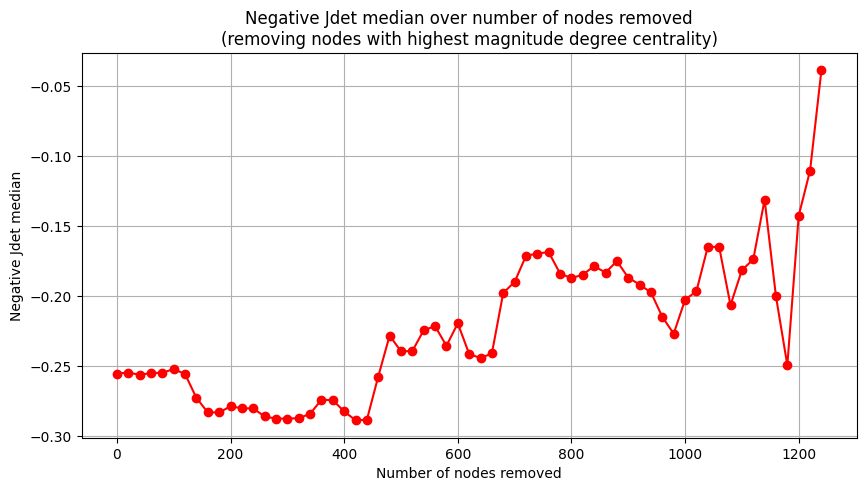

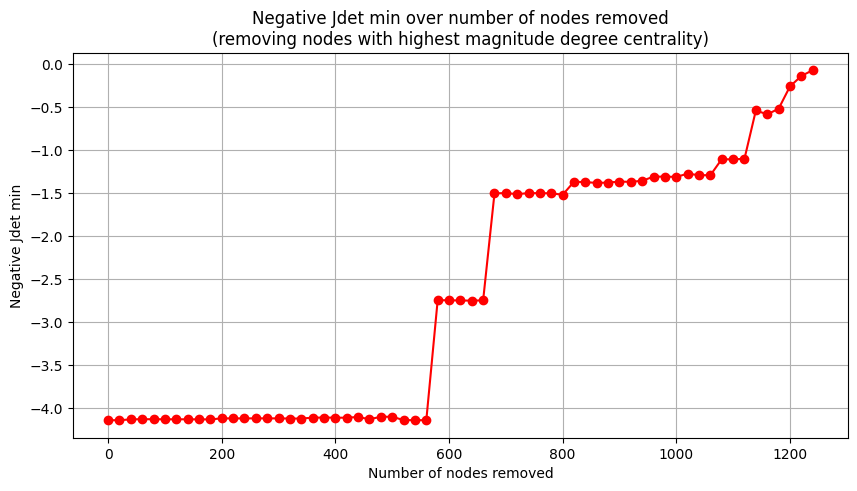

In [297]:
# Number of Jdets
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, num_neg_Jdets, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Number of negative Jdets')
plt.title('Number of negative Jdets over number of nodes removed\n(removing nodes with highest magnitude degree centrality)')
plt.grid(True)
plt.show()

# Jdet mean
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, jdet_mean_list, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Negative Jdet mean')
plt.title('Negative Jdet mean over number of nodes removed\n(removing nodes with highest magnitude degree centrality)')
plt.grid(True)
plt.show()

# Jdet median
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, jdet_median_list, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Negative Jdet median')
plt.title('Negative Jdet median over number of nodes removed\n(removing nodes with highest magnitude degree centrality)')
plt.grid(True)
plt.show()

# Jdet min
plt.figure(figsize=(10, 5))
plt.plot(N_to_remove, jdet_min_list, marker='o', linestyle='-', color='r')
plt.xlabel('Number of nodes removed')
plt.ylabel('Negative Jdet min')
plt.title('Negative Jdet min over number of nodes removed\n(removing nodes with highest magnitude degree centrality)')
plt.grid(True)
plt.show()

## Combine both graphs together

In [163]:
def combine_graphs_with_weights(G1, G2):
    """
    Combine two graphs into a single weighted graph.
    
    Parameters:
    G1, G2 (networkx.Graph): The input graphs to combine.
    
    Returns:
    networkx.Graph: The combined weighted graph.
    """
    combined_graph = nx.Graph()
    
    # Add nodes from the first graph
    combined_graph.add_nodes_from(G1.nodes())
    combined_graph.add_nodes_from(G2.nodes())

    # Add edges from the first graph with weight 1
    for u, v in G1.edges():
        if combined_graph.has_edge(u, v):
            combined_graph[u][v]['weight'] += 1
        else:
            combined_graph.add_edge(u, v, weight=1)

    # Add edges from the second graph with weight 1
    for u, v in G2.edges():
        if combined_graph.has_edge(u, v):
            combined_graph[u][v]['weight'] += 1
        else:
            combined_graph.add_edge(u, v, weight=1)

    return combined_graph


def get_weighted_degrees(G):
    """
    Get the weighted degrees of all nodes in a weighted graph.
    
    Parameters:
    G (networkx.Graph): The weighted graph.
    
    Returns:
    dict: A dictionary with nodes as keys and their weighted degrees as values.
    """
    return {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}



def get_weighted_degree(G, node):
    """
    Get the sum of all weighted connections to a node in a weighted graph.
    
    Parameters:
    G (networkx.Graph): The weighted graph.
    node (int or str): The node to get the weighted degree of.
    
    Returns:
    float: The sum of all weighted connections to the node.
    """
    return sum(data['weight'] for _, _, data in G.edges(node, data=True))

In [164]:
conflict_graph = combine_graphs_with_weights(orientation_graph, magnitude_graph)

Conflict graph
Number of nodes: 1074
Top 10 nodes by weighted degree:
Node 673: 25
Node 846: 21
Node 536: 18
Node 897: 15
Node 27: 14
Node 907: 14
Node 950: 14
Node 539: 13
Node 847: 13
Node 850: 13


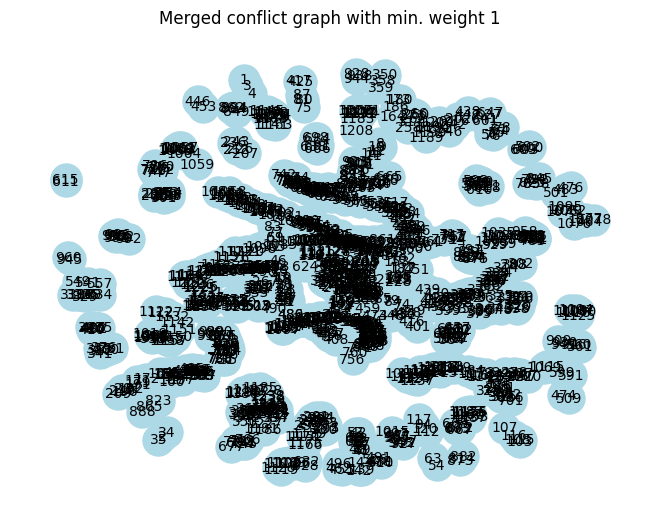

In [165]:
MIN_WEIGHT = 1

# Get the weighted degrees
weighted_degrees = get_weighted_degrees(conflict_graph)
# Sort the nodes by weighted degree in descending order and get the top 10
sorted_weighted_degrees = sorted(weighted_degrees.items(), key=lambda item: item[1], reverse=True)


# Filter nodes with degrees above MIN_DEGREE
filtered_nodes = [node for node, weight in weighted_degrees.items() if weight >= MIN_WEIGHT]
filtered_G = conflict_graph.subgraph(filtered_nodes)  # Create a subgraph with the filtered nodes

# Print information
print("Conflict graph")
print("Number of nodes:", len(filtered_G.nodes))
print("Top 10 nodes by weighted degree:")
for node, weight in sorted_weighted_degrees[:10]:
    print(f"Node {node}: {weight}")

# Draw the filtered graph
pos = nx.spring_layout(filtered_G)
edges = filtered_G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

nx.draw(filtered_G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, width=weights)
nx.draw_networkx_edge_labels(filtered_G, pos, edge_labels={(u, v): d['weight'] for u, v, d in filtered_G.edges(data=True)})
plt.title(f"Merged conflict graph with min. weight {MIN_WEIGHT}")
plt.show()

In [159]:
idx = 673
print("Magnitude degree:", magnitude_graph.degree(idx))
print("Orientation degree:", orientation_graph.degree(idx))
print("Conflict degree:", get_weighted_degree(conflict_graph, idx))

Magnitude degree: 13
Orientation degree: 12
Conflict degree: 25


## Remove conflicts

In [191]:
top_N = 1240
outlier_indices = np.array(sorted_weighted_degrees[:top_N])[:, 0]

# Remove outlier indices from moving and fixed points
mpoints_new = np.delete(mpoints_corrected.copy(), outlier_indices, axis=0)
fpoints_new = np.delete(fpoints_corrected.copy(), outlier_indices, axis=0)
cvectors_new = np.delete(cvectors_corrected.copy(), outlier_indices, axis=0)

print("Number of points originally:", len(mpoints_corrected))
print("Number of points after removal:", len(mpoints_new))

Number of points originally: 1246
Number of points after removal: 6


fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.1031949520111084s
Computing dy
dy calculated in 0.2187943458557129s
Computing dx
dx calculated in 0.31951475143432617s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.10306954383850098s
Computing dy
dy calculated in 0.2877821922302246s
Computing dx
dx calculated in 0.5113852024078369s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 168
Before - minimum Jacobian determinant: -4.141267670622895
Before - maximum Jacobian determinant: 8.847872374160026

After - number of negative or zero Jacobian determinants: 0
After - minimum Jacobian determinant: 0.14049368113437324
After - maximum Jacobian determinant: 1.8595064553522513



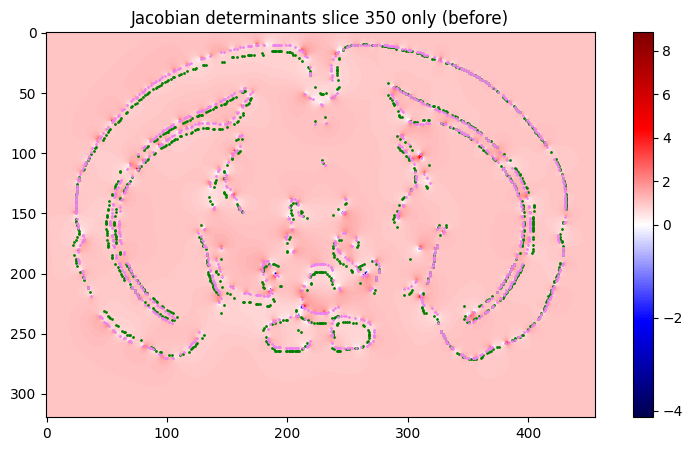

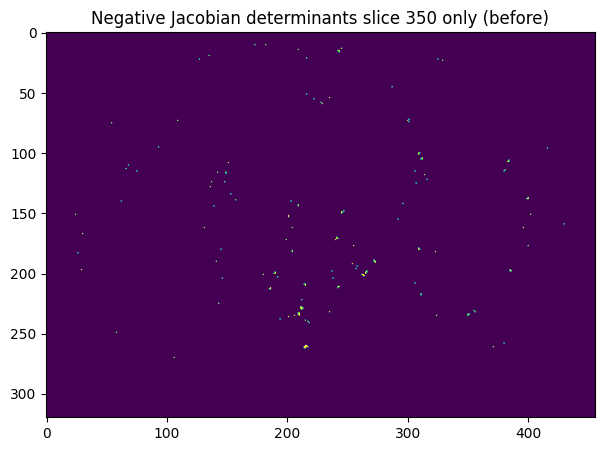

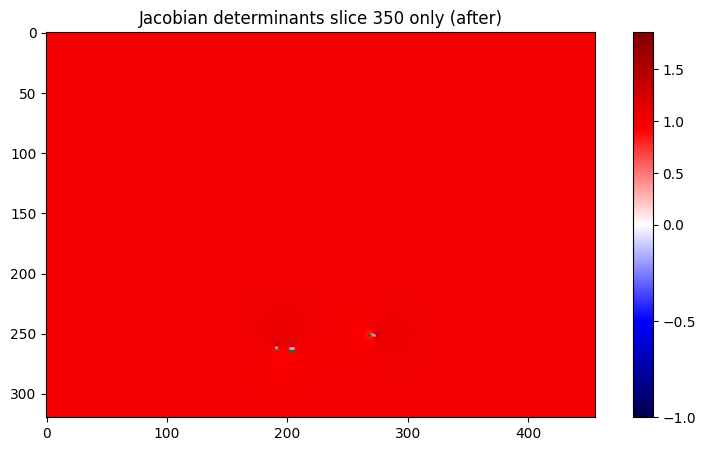

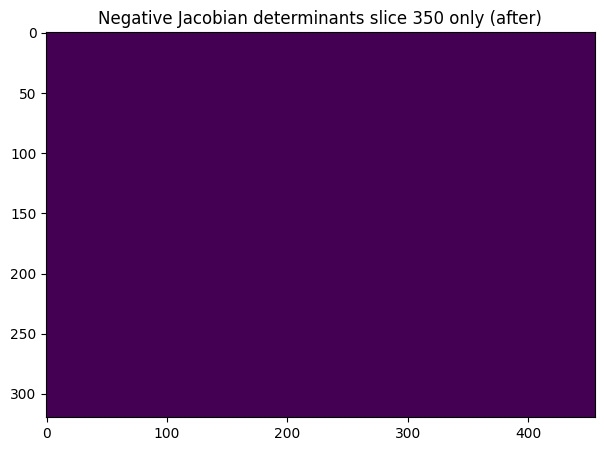

In [192]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_new, fpoints_new)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print() 

if np.sum(jdet_corrected <= 0) > 0:
    get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_new[:, 2], mpoints_new[:, 1], c="g", s=1)
plt.scatter(fpoints_new[:, 2], fpoints_new[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()